In [1]:
# Imports
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directories to the path
sys.path.append("../Models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../Data/")
from VesselsDatasetLoader import get_dataloader, get_dataset

torch.cuda.empty_cache()

In [2]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cpu")

batch_size = 8

dataloader = get_dataloader(batch_size = batch_size)

dataset_type = 'vessel'

Total number of batches: 331


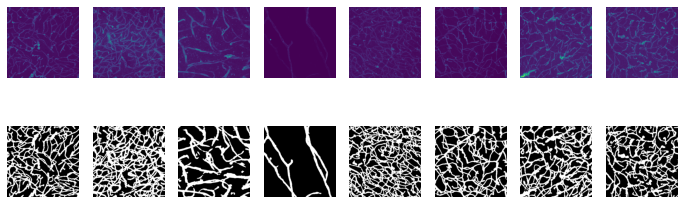

In [3]:
num_batches = len(dataloader)
print("Total number of batches:", num_batches)


# Iterate over the first few batches
for i, (images, masks) in enumerate(dataloader):
    if i >= 1:  # Display only the first batch
        break
    # Display images and masks
    fig, axs = plt.subplots(2, len(images), figsize=(12, 4))
    for j in range(len(images)):
        axs[0, j].imshow(images[j].permute(1, 2, 0))  # Assuming images are in (C, H, W) format
        axs[1, j].imshow(masks[j][0], cmap='gray')    # Assuming masks are in (C, H, W) format and C=1
        axs[0, j].axis('off')
        axs[1, j].axis('off')
    plt.show()

In [ ]:
331 * 8

In [4]:
train_size = 0.8  # e.g., 80% for training

# Loading datasets
train_loader, test_loader = get_dataset(batch_size, train_size)

In [5]:
# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def sum_params(model, mode='l2'):
    s = 0
    for param in model.parameters():
        if mode == 'l2':
            s += (param ** 2).sum()
        else:
            s += param.abs().sum()
    return s

In [6]:
# Placeholders for metrics
train_losses = []
train_aux_losses = []
test_losses = []
test_accuracies = []
test_ious = []

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 

# Regularization mode and hyperparameters
regularization_mode = 'l1'  # Options: 'none', 'l1', 'l2'
alpha_l1 = 0.00001  # Only used for L1 regularization
alpha_l2 = 0.0001  # Only used for L2 regularization
num_epochs = 50

weight_decay = 1e-4 if regularization_mode == 'l2' else 0

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
# Watch scheduler, it reduces LR depend upon on loss, plot LR, acess from optimizer
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

In [7]:
# Training loop
for epoch in range(num_epochs):
    model.train() 
    aux_loss = 0.0
    running_aux_loss = 0.0
    running_loss, train_iou = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        labels = labels.squeeze(1).long()  # Adjusting the shape of labels for CrossEntropyLoss

        optimizer.zero_grad()

        outputs = model(inputs)
        
        # Calculate the base loss
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Add L1 regularization if specified
        if regularization_mode == 'l1':
            aux_loss = alpha_l1 * sum_params(model, mode='l1')
            running_aux_loss += aux_loss
            loss += aux_loss
        
        # Add L2 regularization if specified
        if regularization_mode == 'l2':
            aux_loss = alpha_l2 * sum_params(model, mode='l2')
            running_aux_loss += aux_loss
            loss += aux_loss

        _, predicted = torch.max(outputs.data, 1)
        train_iou += iou_metric(labels.float(), predicted.float())
        loss.backward()
        optimizer.step()


    # Calculate and print the average training loss
    avg_train_loss = running_loss / len(train_loader)
    train_iou /= len(train_loader)
    
    train_losses.append(avg_train_loss)
    
    # Calculate and print the average training aux loss
    avg_train_aux_loss = running_aux_loss / len(train_loader)
    train_aux_losses.append(avg_train_aux_loss)

    # Validation
    model.eval()  
    test_loss = 0.0
    total_iou = 0.0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            labels = labels.squeeze(1).long()
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_iou += iou_metric(labels.float(), predicted.float())
    
    avg_test_loss = test_loss / len(test_loader)
    avg_iou = total_iou / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(avg_iou.cpu())
    test_ious.append(avg_iou.cpu())

    scheduler.step(avg_test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Aux Loss: {avg_train_aux_loss:.4f} Test Loss: {avg_test_loss:.4f} Train IoU: {train_iou:.4f} Test IoU: {avg_iou:.4f}')

Epoch [1/50] Train Loss: 0.3148 Aux Loss: 0.7076 Test Loss: 0.3586 Test IoU: 0.6463
Epoch [2/50] Train Loss: 0.2236 Aux Loss: 0.3827 Test Loss: 0.2664 Test IoU: 0.7592
Epoch [3/50] Train Loss: 0.2206 Aux Loss: 0.3222 Test Loss: 0.2554 Test IoU: 0.7721
Epoch [4/50] Train Loss: 0.2147 Aux Loss: 0.3088 Test Loss: 0.2607 Test IoU: 0.7519
Epoch [5/50] Train Loss: 0.2080 Aux Loss: 0.2575 Test Loss: 0.2116 Test IoU: 0.8026
Epoch [6/50] Train Loss: 0.1984 Aux Loss: 0.2277 Test Loss: 0.1961 Test IoU: 0.8112
Epoch [7/50] Train Loss: 0.1927 Aux Loss: 0.2073 Test Loss: 0.2044 Test IoU: 0.8021
Epoch [8/50] Train Loss: 0.1972 Aux Loss: 0.2131 Test Loss: 0.1962 Test IoU: 0.8130
Epoch [9/50] Train Loss: 0.2167 Aux Loss: 0.2552 Test Loss: 0.2185 Test IoU: 0.7920
Epoch [10/50] Train Loss: 0.1920 Aux Loss: 0.2050 Test Loss: 0.3543 Test IoU: 0.6511
Epoch [11/50] Train Loss: 0.1899 Aux Loss: 0.1843 Test Loss: 0.1948 Test IoU: 0.8169
Epoch [12/50] Train Loss: 0.1944 Aux Loss: 0.2028 Test Loss: 0.2039 Test I

TypeError: int() argument must be a string, a bytes-like object or a number, not 'PngImageFile'

In [ ]:
# Saving model
if regularization_mode == 'none':
  torch.save(model.state_dict(), f'../Models/custom_cnn_vessel.pth')
else:
  torch.save(model.state_dict(), f'../Models/custom_cnn_vessel_regularized_{regularization_mode}_{num_epochs}.pth')

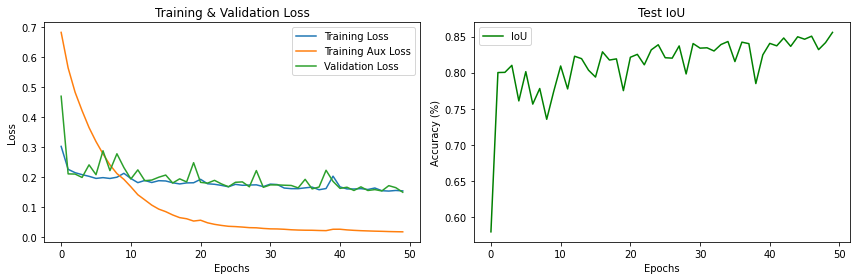

In [ ]:
if regularization_mode == 'none':
  save_path = f'../Models//ModelAnalysis/custom_cnn_vessel'
else:
  save_path = f'../Models/ModelAnalysis/custom_cnn_vessel_regularized_{regularization_mode}_{num_epochs}'


# 4. Plotting metrics
plt.figure(figsize=(12, 4))

# Training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
if regularization_mode != 'none':
  plt.plot([loss.detach().cpu().numpy() for loss in train_aux_losses], label='Training Aux Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
_ = plt.legend()

# Test accuracy
plt.subplot(1, 2, 2)
plt.plot(test_ious, label='IoU', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Test IoU')
_ = plt.legend()
_ = plt.savefig(save_path, bbox_inches='tight', dpi=300, facecolor='white')
_ = plt.tight_layout()
_ = plt.show()

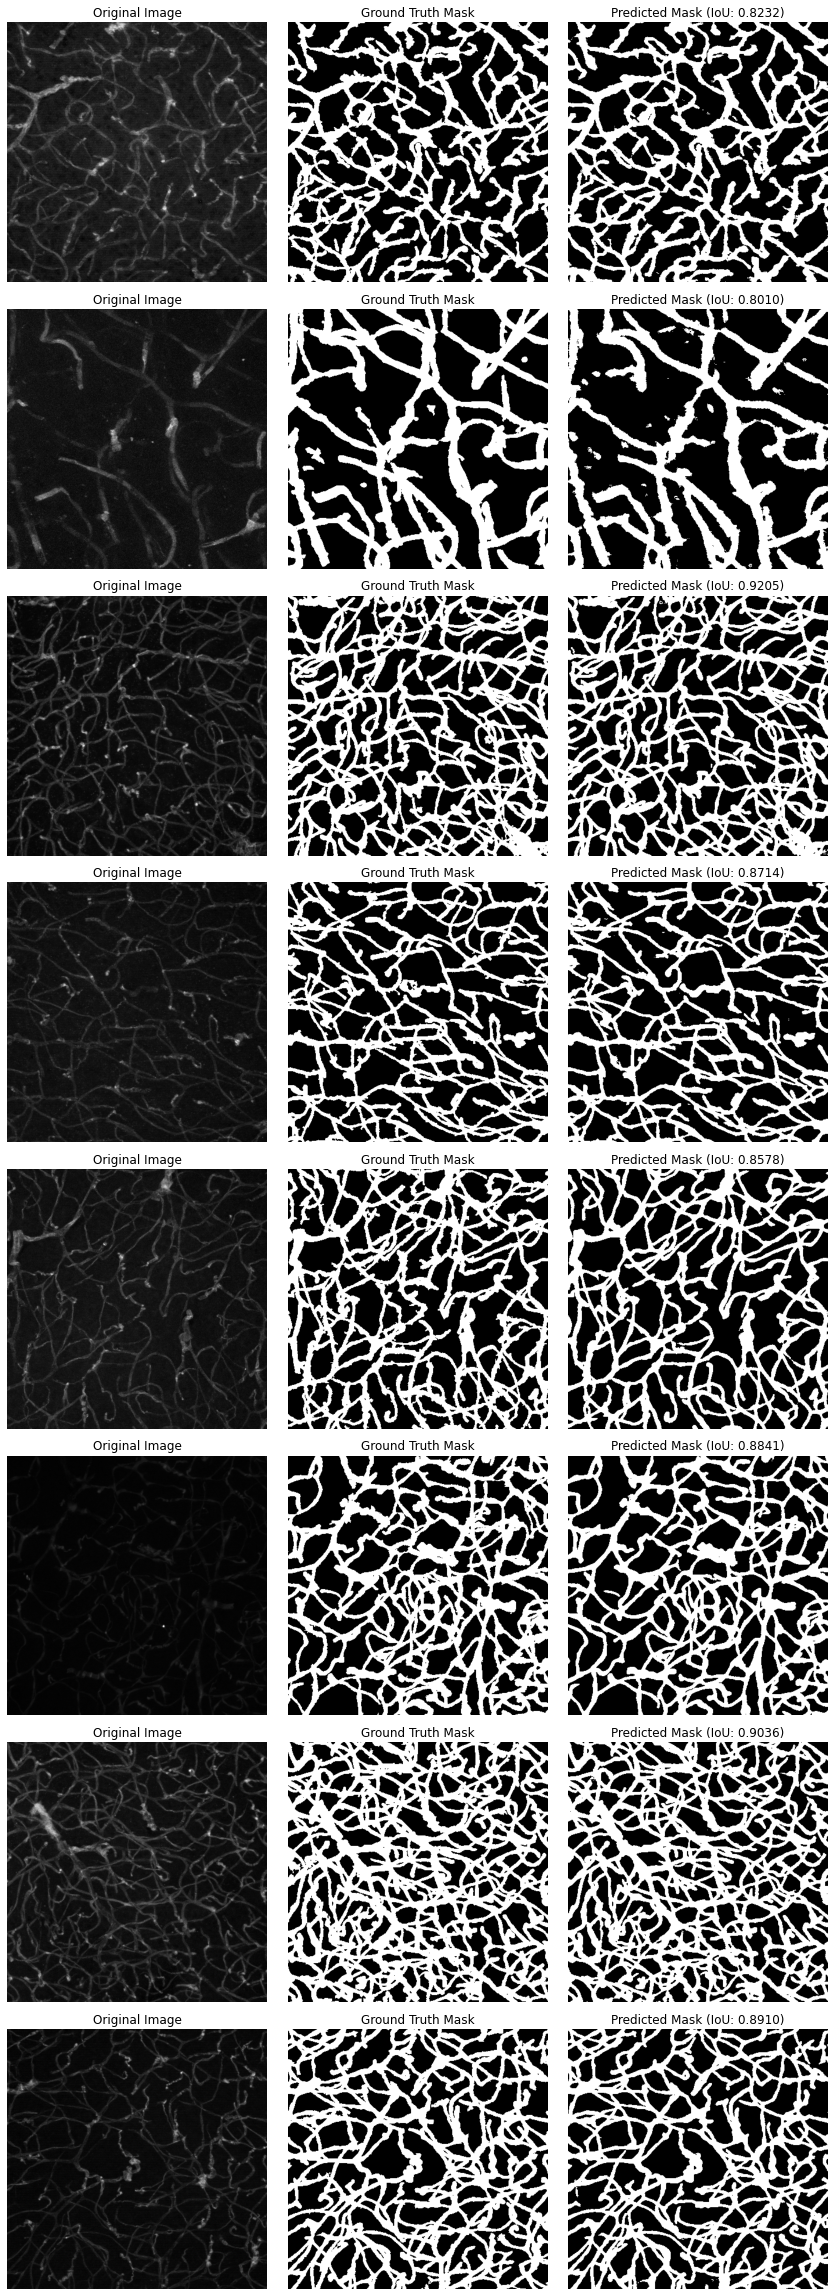

In [ ]:
model.cpu().eval()

# Select a random batch from the test dataset
images, masks = next(iter(test_loader))
if torch.cuda.is_available():
    images, masks = images, masks

# Get model predictions
outputs = model(images)
_, preds = torch.max(outputs, 1)

# Plot the results
fig, axs = plt.subplots(len(images), 3, figsize=(12, len(images)*4))
for idx, (img, mask, pred) in enumerate(zip(images, masks, preds)):
    mask_np = mask.squeeze().cpu().numpy()
    pred_np = pred.squeeze().cpu().numpy()
    
    iou_score = iou_metric(mask_np, pred_np)
    
    
    axs[idx, 0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[idx, 0].set_title('Original Image')
    
    axs[idx, 1].imshow(mask_np, cmap='gray')
    axs[idx, 1].set_title('Ground Truth Mask')
    
    axs[idx, 2].imshow(pred_np, cmap='gray')
    axs[idx, 2].set_title(f'Predicted Mask (IoU: {iou_score:.4f})')

for ax in axs.ravel():
    ax.axis('off')

plt.tight_layout()
plt.show()